In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import nilearn.image, nilearn.masking, nilearn.plotting, nilearn.decoding
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import nibabel as nib
import numpy.linalg as linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
# from PCRegression import PCR
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
#!pushd \\10.201.185.39\clmnlab
#jupyter notebook --ip=0.0.0.0 --port=8080
#jupyter notebook --ip=127.0.0.1

In [3]:
TM_dir = '/clmnlab/TM'
#TM_dir = 'Z:/TM'
#TM_dir = 'E:/data'

behav_dir = TM_dir + '/behav_data/'
fan_roi_dir = TM_dir + '/fMRI_data/masks/Fan/Fan280/'
stats_dir_5 = TM_dir + '/fMRI_data/stats/Reg5_MVPA1_IM_vibration/'
stats_dir_6 = TM_dir + '/fMRI_data/stats/Reg6_MVPA2_IM_VWM/'
stats_dir_7 = TM_dir + '/fMRI_data/stats/Reg7_MVPA3_IM_COY/'
stats_dir_9 = TM_dir + '/fMRI_data/stats/Reg9_MVPA4_IM_vibration/'
preproc_dir = TM_dir + '/fMRI_data/preproc_data/'
Ttest_ROI_mask = TM_dir + '/Clust_mask_binary.nii'

stats_dir = stats_dir_5
subj_list = ["TML04_PILOT","TML05_PILOT","TML06_PILOT","TML07_PILOT", 
            "TML08_PILOT","TML09_PILOT","TML10_PILOT","TML11_PILOT",
            "TML12_PILOT","TML13","TML14","TML15","TML16","TML18","TML19","TML20",
            "TML21","TML22","TML23","TML24","TML25","TML26","TML28","TML29"]
subj = subj_list[0]

freq_range = range(10,20+1,1)
freq_c = freq_range[5]

### Neural data of touching the comparement group

- Freq.index: 비교군이 먼저 오는지, 나중에 오는지  
- LSSout: 한 trial 안에서 beta를 5개씩 구했음  
- 비교군을 만질 때의 neural data를 사용하므로, 비교군이 먼저 온 경우 첫번째 beta, 비교군이 나중에 온 경우 세번째 beta를 선택해야 함(get_label_index_others)  

In [4]:
def calc_freq_class(freq_range, freq):
    #freq_range = range(10,20+1,1)
    freqs = [x for x in freq_range]
    #print(freqs)
    f_mid = int((freqs[0]+freqs[-1])*0.5)
    return int(freq - f_mid)

In [5]:
def get_dataframe(subj, run):
    df = pd.read_csv(behav_dir + subj + '/behav_data_Dis.dat', sep='\t', header=None)
    df.columns=['trial', 'Freq.1', 'ISI1', 'Freq.2', 'ISI2', 'decision', 'correctness', 'RT', 'ISI3']
    df['Freq.1.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.1']]
    df['Freq.2.class'] = [np.int64(np.sign(f-freq_c)) for f in df['Freq.2']]
    df['Freq.other.index'] = [1 if a != 0 else 2 for a in df['Freq.1.class']]
    df['Freq.other.class'] = [a+b for a, b in zip(df['Freq.1.class'], df['Freq.2.class'])]
    df['answer.index'] = [1 if a>b else 2 for a, b in zip(df['Freq.1'], df['Freq.2'])]
    df['decision.index'] = [1 if x == 'before' else (2 if x=='after' else 'NaN') for i, x in enumerate(df['decision'])]
    df['Freq.other_decision.class'] = ['NaN' if b=='NaN' else (1 if a==b else -1) for a,b in zip(df['Freq.other.index'],df['decision.index'])]

    df['Freq.1.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.1']]
    df['Freq.2.rank'] = [calc_freq_class(freq_range,f) for f in df['Freq.2']]
    df['Freq.other.rank'] = [a+b for a, b in zip(df['Freq.1.rank'], df['Freq.2.rank'])]
    df['F1<F2.class'] = [np.sign(b-a) for a, b in zip(df['Freq.1'], df['Freq.2'])]

    temp = []
    trials = [40, 30, 30]
    fin = 0
    for x in trials:
        ini = fin
        fin = ini + x
        temp.append(df.loc[ini:fin-1])

    # Note, Freq.other_answer.class == Freq.other_updown.class
    #validation = df['Freq.other_answer.class'] == df['Freq.other.classifier']
    #assert validation.all() == True
    #assert df['Freq.other_decision.class'].shape[0] == sum(trials)
    assert len(temp[run-1]) == trials[run-1]

    return temp[run-1]

In [6]:
def load_freq_all(subj, run):
    df = get_dataframe(subj, run)
    df = pd.DataFrame.reset_index(df)

    temp = [[df.loc[row,'Freq.1'],df.loc[row,'Freq.2']] for row in range(len(df))]
    temp = np.concatenate(temp)
    #temp = pd.DataFrame(temp)

    return temp

In [7]:
def get_label_index(subj, run, num_beta, target_idx):
## labeling betas of others indices ##
## e.g.) ##
## beta_1st, beta_2nd, beta_3rd, beta_4th, beta_5th : nbeta = 5 ##
## freq_before, ISI1, freq_after, ISI2r, Yellow : target_idx = 1 or 3 ##
## others : frequencies which are not equal to center frequency ##
    nbeta = num_beta   # number of betas in one trial
    tb = target_idx   # target_idx, (The index starts from 1)

    list_freq = load_freq_all(subj, run)
    idx_center = []
    idx_other = []
    for r, x in enumerate(list_freq):
        t = r//2            # r = 0, 1, 2, 3, ... // trial >> t = 0, 0, 1, 1, 2, 2, ...
        isbefore = (r+1)%2  # where r is even number means f_before
        isafter = r%2       # where r is odd number means f_after
        
        idx = np.int64( nbeta*t + (tb[0]*isbefore + tb[1]*isafter) - 1 )
        
        if x != freq_c:
            idx_other.append(idx)
        else:
            idx_center.append(idx)

    return idx_center, idx_other

In [8]:
def load_beta_image(subj, run):
## load nilearn image ##
    img = nilearn.image.load_img(stats_dir + '%s/r%02d.LSSout.nii.gz' % (subj, run))
    idx_center, idx_other = get_label_index(subj, run, 5, [1,3])
    img_center = nilearn.image.index_img(img, idx_center)
    img_other = nilearn.image.index_img(img, idx_other)

    return img_center, img_other

In [9]:
def load_target(subj, run):
## load behavior data and make up them ##
    df = get_dataframe(subj, run)
    classifier = list(df['Freq.other.class'])
    regressor = list(df['Freq.other.rank'])

    assert sum(classifier) == 0
    assert sum(regressor) == 0

    return classifier, regressor

In [10]:
def load_target_freq_others(subj):
## load frequencies which are not equal to freq_center sequentially
    df = pd.read_csv(behav_dir + '%s/behav_data_Dis.dat'% subj, sep='\t', header=None)
    freq = list(np.int64(np.where(df[1]!=freq_c,df[1],df[3])))

    return freq

### X & y & grouping

In [11]:
### X: neural data / y: answers / group: run number
def get_X_y_group(subj, runs):      
    cXs = []
    Xs = []
    ys = []
    for run in runs:
        img1, img2 = load_beta_image(subj, run)
        cXs += [img1]
        Xs += [img2]
        c, r = load_target(subj, run)
        ys += [c]

    group = [
        i for i, y in enumerate(ys) for j in range(len(y))
    ]
    Xs = nilearn.image.concat_imgs(Xs)
    cXs = nilearn.image.concat_imgs(cXs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    return Xs, cXs, ys, group

### ROI Masking
- Group ROI사용

In [12]:
def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)

    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))

    return img_data[roi_mask,:]

In [13]:
label_data = TM_dir + '/fMRI_data/masks/Fan/Fan280/fan280_fullname.csv'
fan_roi = pd.read_csv(label_data, header=None)
fan_roi = fan_roi.rename(columns={0: 'label'})

fan_roi_path = sorted(glob.glob(fan_roi_dir + 'fan.roi.resam.*.nii.gz'))
fan_roi_imgs = np.array([nilearn.image.load_img(path) for path in fan_roi_path])
len_roi = fan_roi.shape[0]

for i in range(len(fan_roi_path)):
    row = int(fan_roi_path[i][-10:-7])-1
    fan_roi.loc[row,'imgs'] = fan_roi_imgs[i]
    fan_roi.loc[row,'nvoxels'] = np.sum(fan_roi_imgs[i].get_fdata()>0,axis=None)

In [14]:
fan_roi

label  \
0          Lt. superior frontal gyrus (BA8, medial)   
1          Rt. superior frontal gyrus (BA8, medial)   
2    Lt. superior frontal gyrus (BA8, dorsolateral)   
3    Rt. superior frontal gyrus (BA8, dorsolateral)   
4         Lt. superior frontal gyrus (BA9, lateral)   
..                                              ...   
275                             Periaqueductal gray   
276                            Lt. substantia nigra   
277                            Rt. substantia nigra   
278                                 Lt. red nucleus   
279                                 Rt. red nucleus   

                                                  imgs  nvoxels  
0    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    694.0  
1    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    858.0  
2    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    873.0  
3    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    710.0  
4    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    737.0  
..                                                 ...      ...  
275  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...    328.0  
276  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...     42.0  
277  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...     42.0  
278  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...      1.0  
279  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...      1.0  

[280 rows x 3 columns]

### Normalize (Z-score)
#### This progress is same as sklearn.preprocessing.scale

In [13]:
def normalize_img(img):
    #axis = len(img.shape)-1
    axis = 0
    sd = np.std(img,axis=axis)
    boolnotzero = (sd>0)
    norm_img = stats.zscore(img[:,boolnotzero],axis=axis)
    return norm_img

### Write nifti images

In [14]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

## SVC

In [12]:
clf = LinearSVC(max_iter=int(1e3))
clf

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [20]:
len_roi = fan_roi_imgs.shape[0]
idx = np.int64([fan_roi_path[i][-10:-7] for i in range(len_roi)]) - 1
temp = [fan_roi_label.loc[i,0] for i in idx]
df = pd.DataFrame(index=temp)
for i, subj in enumerate(subj_list):
    Xs, cXs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)

    crr = np.zeros(len_roi)
    scr = np.zeros(len_roi)

    for i, roi in enumerate(fan_roi_imgs):
        ## ROI analysis ##
        temp = fast_masking(img=Xs, roi=roi)
        nvoxels = temp.shape[0]

        XT = temp.T
        Ypred = np.zeros(100)
        n_components = 0.95
        #dg = pd.DataFrame()
        col = 0
        for idx_train, idx_test in cv.split(XT, ys, group):
            # print(Xtrans[idx_test,:].shape,Xtrans[idx_train,:].shape)  >>> (nX*nY*nZ,ntrain)
            # n_components = ntrial
            Xtrain = XT[idx_train,:]
            Ytrain = ys[idx_train]
            clf.fit(scale(Xtrain),Ytrain)
            Xtest = XT[idx_test,:]  # (ntrials,nvoxels)
            Ypred[idx_test] = clf.predict(scale(Xtest))
            #evr = pcr.explained_variance_ratio_
            #dg[col] = evr
            #col += 1
        da = pd.DataFrame()
        da['ys'] = ys
        da['Ypred'] = np.int64(Ypred)
        da['correctness'] = [bool(i*j+1) for i,j in zip(da['ys'],da['Ypred'])]
        crr[i] = sum(da['correctness'])/len(da['correctness'])
        scr[i] = clf.score(scale(XT),ys)
    df[subj] = crr

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [21]:
df

TML23
Lt. superior frontal gyrus (BA8, medial)         0.47
Rt. superior frontal gyrus (BA8, medial)         0.42
Lt. superior frontal gyrus (BA8, dorsolateral)   0.52
Rt. superior frontal gyrus (BA8, dorsolateral)   0.35
Lt. superior frontal gyrus (BA9, lateral)        0.50
...                                               ...
Periaqueductal gray                              0.52
Lt. substantia nigra                             0.38
Rt. substantia nigra                             0.47
Lt. red nucleus                                  0.43
Rt. red nucleus                                  0.58

[279 rows x 1 columns]

In [22]:
dg = df.transpose()
dg

Lt. superior frontal gyrus (BA8, medial)  \
TML23                                      0.47   

       Rt. superior frontal gyrus (BA8, medial)  \
TML23                                      0.42   

       Lt. superior frontal gyrus (BA8, dorsolateral)  \
TML23                                            0.52   

       Rt. superior frontal gyrus (BA8, dorsolateral)  \
TML23                                            0.35   

       Lt. superior frontal gyrus (BA9, lateral)  \
TML23                                        0.5   

       Rt. superior frontal gyrus (BA9, lateral)  \
TML23                                       0.62   

       Lt. superior frontal gyrus (BA6, dorsolateral)  \
TML23                                            0.43   

       Rt. superior frontal gyrus (BA6, dorsolateral)  \
TML23                                            0.48   

       Lt. superior frontal gyrus (BA6, medial)  \
TML23                                      0.42   

       Rt. superior frontal gyrus (BA6, medial)  ...  \
TML23                                      0.51  ...   

       Lt. cerebellum (lobule X)  Vermis. cerebellum (lobule X)  \
TML23                       0.44                           0.54   

       Rt. cerebellum (lobule X)  Hypothalamus  Brainstem  \
TML23                       0.45           0.6       0.51   

       Periaqueductal gray  Lt. substantia nigra  Rt. substantia nigra  \
TML23                 0.52                  0.38                  0.47   

       Lt. red nucleus  Rt. red nucleus  
TML23             0.43             0.58  

[1 rows x 279 columns]

[(0, 0.9)]

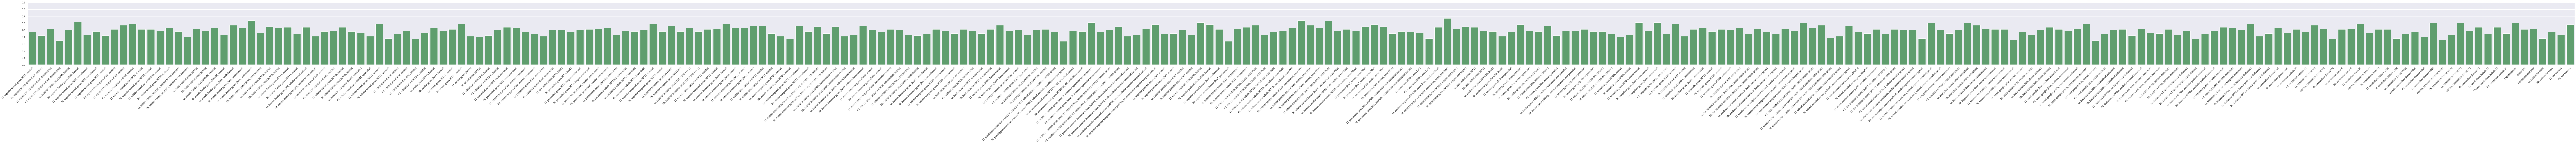

In [23]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=dg,ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0, 0.9))

In [15]:
def get_label_2nd_index(subj, run, nbeta=2, target_idx=1):
## labeling betas of others indices
## e.g.)
## beta_1st, beta_2nd, beta_3rd, beta_4th, beta_5th : nbeta = 5
## freq_before, ISI1, freq_after, ISI2r, Yellow : target_idx = 0 or 2
    list_freq = load_freq_all(subj, run)
    ntrials = int(len(list_freq)*0.5)
    
    idx_2nd = [ nbeta*i + target_idx for i in range(ntrials) ]

    return np.array(idx_2nd)

In [16]:
def load_beta_2nd_image(subj, run):
## load nilearn image ##
    img = nilearn.image.load_img(stats_dir_9 + '%s/r%02d.LSSout.nii.gz' % (subj, run))
    idx = get_label_2nd_index(subj, run)
    temp = nilearn.image.index_img(img, idx)

    return temp

In [17]:
def load_2nd_target(subj, run):
## load behavior data and make up them ##
    df = get_dataframe(subj, run)
    classifier = list(df['F1<F2.class'])

    return classifier

In [18]:
### X: neural data / y: answers / group: run number
def get_X_y_group(subj, runs):      

    Xs = [ load_beta_2nd_image(subj, run) for run in runs ]
    ys = [ load_2nd_target(subj, run) for run in runs ]
    group = [ i for i, y in enumerate(ys) for j in range(len(y)) ]
    
    Xs = nilearn.image.concat_imgs(Xs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    return Xs, ys, np.array(group)

In [19]:
clf_svc = LinearSVC(C=1., max_iter=int(5e3))
clf_svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
temp = fan_roi['label']
df = pd.DataFrame(index=temp)
for subj in subj_list:
    Xs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)
    crr = np.zeros(len_roi)
    mscr = np.zeros(len_roi)
    for i, n in enumerate(fan_roi['nvoxels']):
        roi = fan_roi.loc[i,'imgs']
        if np.isnan(n):
            continue
        ## fan ROI analysis ##
        temp = fast_masking(img=Xs, roi=roi)
        nvoxels = temp.shape[0]
        XT = temp.T
        Ypred = np.zeros(100)
        scr = np.zeros(k)
        for idx_train, idx_test in cv.split(XT, ys, group):
            g = int(np.unique(group[idx_test]))
            Xtrain = scale(XT[idx_train,:])
            Ytrain = ys[idx_train]
            clf.fit(Xtrain,Ytrain)
            Xtest = scale(XT[idx_test,:])
            Ypred[idx_test] = clf.predict(Xtest)
            scr[g] = clf.score(Xtest,ys[idx_test])
        da = pd.DataFrame()
        da['ys'] = ys
        da['Ypred'] = np.int64(Ypred)
        da['correctness'] = [bool(p*q+1) for p,q in zip(da['ys'],da['Ypred'])]
        crr[i] = sum(da['correctness'])/len(da['correctness'])
        mscr[i] = np.mean(scr)
    df[subj] = mscr

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, i

In [23]:
df.transpose()

label        Lt. superior frontal gyrus (BA8, medial)  \
TML04_PILOT                                  0.547222   
TML05_PILOT                                  0.458333   
TML06_PILOT                                  0.394444   
TML07_PILOT                                  0.522222   
TML08_PILOT                                  0.636111   
TML09_PILOT                                  0.497222   
TML10_PILOT                                  0.569444   
TML11_PILOT                                  0.491667   
TML12_PILOT                                  0.455556   
TML13                                        0.547222   
TML14                                        0.522222   
TML15                                        0.519444   
TML16                                        0.497222   
TML18                                        0.538889   
TML19                                        0.494444   
TML20                                        0.555556   
TML21                                        0.500000   
TML22                                        0.519444   
TML23                                        0.455556   
TML24                                        0.538889   
TML25                                        0.505556   
TML26                                        0.602778   
TML28                                        0.505556   
TML29                                        0.511111   

label        Rt. superior frontal gyrus (BA8, medial)  \
TML04_PILOT                                  0.552778   
TML05_PILOT                                  0.511111   
TML06_PILOT                                  0.444444   
TML07_PILOT                                  0.441667   
TML08_PILOT                                  0.641667   
TML09_PILOT                                  0.566667   
TML10_PILOT                                  0.586111   
TML11_PILOT                                  0.480556   
TML12_PILOT                                  0.533333   
TML13                                        0.547222   
TML14                                        0.538889   
TML15                                        0.438889   
TML16                                        0.511111   
TML18                                        0.472222   
TML19                                        0.522222   
TML20                                        0.516667   
TML21                                        0.497222   
TML22                                        0.633333   
TML23                                        0.569444   
TML24                                        0.436111   
TML25                                        0.475000   
TML26                                        0.541667   
TML28                                        0.552778   
TML29                                        0.425000   

label        Lt. superior frontal gyrus (BA8, dorsolateral)  \
TML04_PILOT                                        0.494444   
TML05_PILOT                                        0.561111   
TML06_PILOT                                        0.413889   
TML07_PILOT                                        0.597222   
TML08_PILOT                                        0.647222   
TML09_PILOT                                        0.447222   
TML10_PILOT                                        0.475000   
TML11_PILOT                                        0.538889   
TML12_PILOT                                        0.433333   
TML13                                              0.438889   
TML14                                              0.522222   
TML15                                              0.550000   
TML16                                              0.591667   
TML18                                              0.444444   
TML19                                              0.511111   
TML20                                              0.502778   
TML21                                              0.563889   
TML22         

[(0, 0.9)]

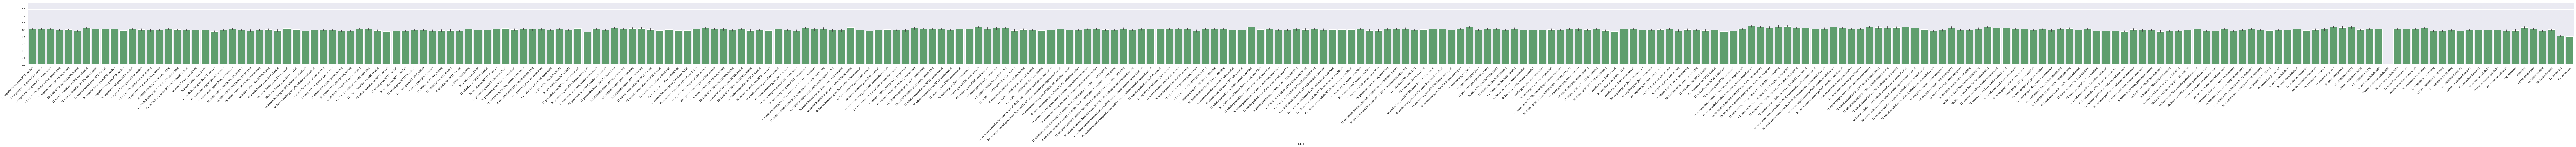

In [24]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=df.transpose(),ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0, 0.9))

In [62]:
subj_list = ["TML04_PILOT","TML05_PILOT","TML06_PILOT","TML07_PILOT", 
            "TML08_PILOT","TML09_PILOT","TML10_PILOT","TML11_PILOT",
            "TML12_PILOT","TML13","TML14","TML15","TML16","TML18","TML19","TML20",
            "TML21","TML22","TML23","TML24","TML25","TML26","TML28","TML29"]

In [92]:
clf_svc = LinearSVC(C=1e0, max_iter=int(1e3))
clf_svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [93]:
df = pd.DataFrame()
for subj in subj_list:
    Xs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)
    ## ROI analysis ##
    roi = nilearn.image.load_img(Ttest_ROI_mask)
    temp = fast_masking(img=Xs, roi=roi)
    nvoxels = temp.shape[0]
    XT = temp.T
    Ypred = np.zeros(100)
    scr = np.zeros(k)
    for idx_train, idx_test in cv.split(XT, ys, group):
        g = int(np.unique(group[idx_test]))
        Xtrain = scale(XT[idx_train,:])
        Ytrain = ys[idx_train]
        clf.fit(Xtrain,Ytrain)
        Xtest = scale(XT[idx_test,:])
        Ypred[idx_test] = clf.predict(Xtest)
        scr[g] = clf.score(Xtest,ys[idx_test])
    df[subj] = [np.mean(scr)]

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [94]:
df

TML04_PILOT  TML05_PILOT  TML06_PILOT  TML07_PILOT  TML08_PILOT  \
0     0.597222     0.655556     0.588889          0.5     0.655556   

   TML09_PILOT  TML10_PILOT  TML11_PILOT  TML12_PILOT     TML13  ...  \
0     0.594444     0.686111     0.644444     0.558333  0.538889  ...   

      TML19     TML20     TML21     TML22     TML23     TML24     TML25  \
0  0.522222  0.630556  0.677778  0.544444  0.836111  0.452778  0.586111   

      TML26     TML28     TML29  
0  0.591667  0.458333  0.588889  

[1 rows x 24 columns]

[(0, 0.9)]

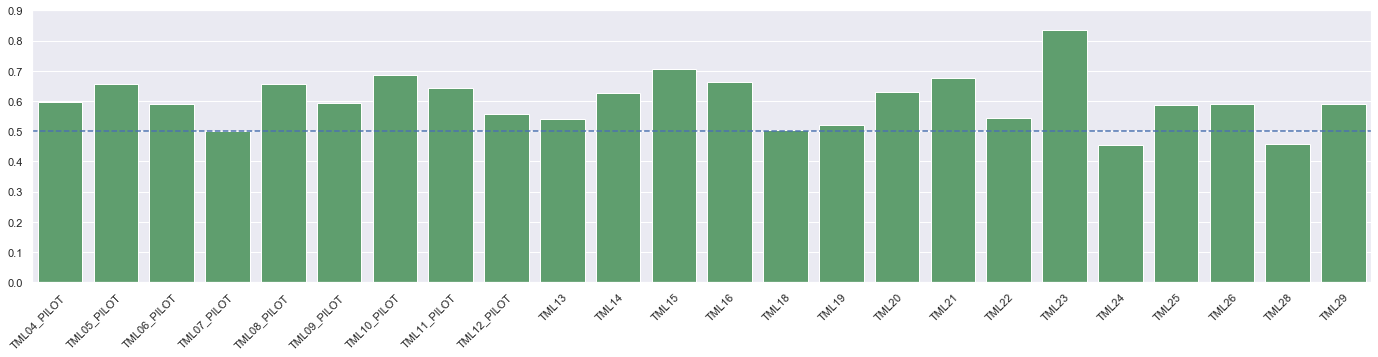

In [95]:
sns.set(rc={'figure.figsize':(24,5)})
ax = sns.barplot(data=df,ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0, 0.9))

In [97]:
clf_svc = LinearSVC(C=1e0, max_iter=int(1e3))
clf_svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [100]:
df = pd.DataFrame()
for subj in subj_list:
    Xs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)
    ## whole brain analysis ##
    roi = nilearn.image.load_img(preproc_dir+'%s/preprocessed/full_mask.%s.nii.gz'%(subj,subj))
    temp = fast_masking(img=Xs, roi=roi)
    nvoxels = temp.shape[0]
    XT = temp.T
    Ypred = np.zeros(100)
    scr = np.zeros(k)
    for idx_train, idx_test in cv.split(XT, ys, group):
        g = int(np.unique(group[idx_test]))
        Xtrain = scale(XT[idx_train,:])
        Ytrain = ys[idx_train]
        clf.fit(Xtrain,Ytrain)
        Xtest = scale(XT[idx_test,:])
        Ypred[idx_test] = clf.predict(Xtest)
        scr[g] = clf.score(Xtest,ys[idx_test])
    df[subj] = [np.mean(scr)]

E:\Program Files\Anaconda3\envs\test\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [101]:
df

TML04_PILOT  TML05_PILOT  TML06_PILOT  TML07_PILOT  TML08_PILOT  \
0     0.594444     0.683333     0.544444     0.516667     0.708333   

   TML09_PILOT  TML10_PILOT  TML11_PILOT  TML12_PILOT     TML13  ...  \
0     0.566667     0.722222        0.675     0.611111  0.569444  ...   

      TML19  TML20     TML21     TML22  TML23     TML24     TML25  TML26  \
0  0.433333    0.6  0.627778  0.505556  0.825  0.458333  0.588889  0.625   

      TML28     TML29  
0  0.411111  0.630556  

[1 rows x 24 columns]

[(0, 0.9)]

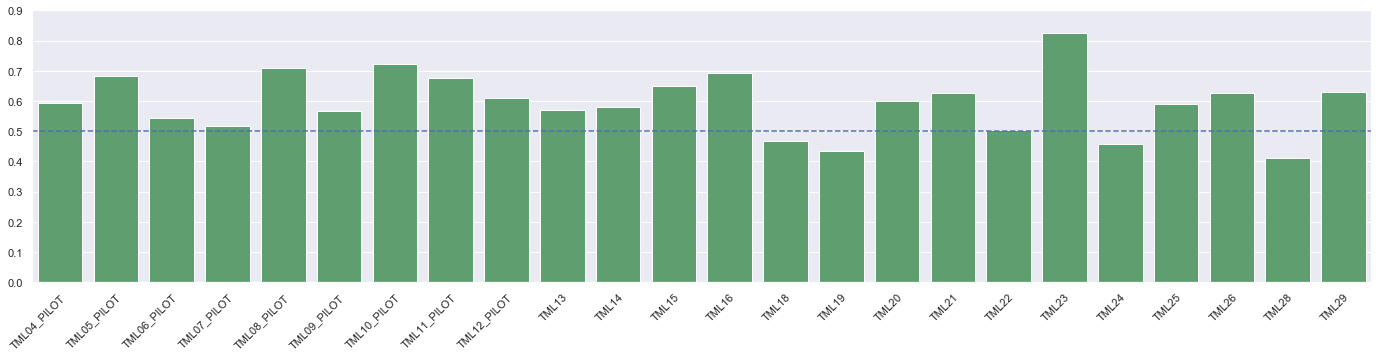

In [102]:
sns.set(rc={'figure.figsize':(24,5)})
ax = sns.barplot(data=df,ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0, 0.9))

### LASSO(Least Absolute Shrinkage and Selection Operator) regression

In [21]:
subj_list = ["TML13","TML14","TML15","TML16","TML18","TML19","TML20",
            "TML21","TML22","TML23","TML24","TML25","TML26","TML28","TML29"]

In [22]:
clf_lasso = LogisticRegression(penalty='l1',solver='saga',max_iter=int(2e3))
clf_lasso

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
nsubjs = len(subj_list)
scrs = np.ones((nsubjs,k))*np.nan
for h, subj in enumerate(subj_list):
    print(subj)
    Xs, ys, group = get_X_y_group(subj, [1,2,3])
    k = len(np.unique(group))
    cv = GroupKFold(k)
    ## whole brain analysis ##
    full_mask = TM_dir + '/fMRI_data/masks/full_masks/full_mask.%s.nii.gz' %subj
    roi = nilearn.image.load_img(full_mask)
    temp = fast_masking(img=Xs, roi=roi)
    nvoxels = temp.shape[0]
    XT = temp.T
    Ypred = np.zeros(100)
    for idx_train, idx_test in cv.split(XT, ys, group):
        g = int(np.unique(group[idx_test]))
        print(g)
        Xtrain = scale(XT[idx_train,:])
        Ytrain = ys[idx_train]
        clf_lasso.fit(Xtrain,Ytrain)
        Xtest = scale(XT[idx_test,:])
        Ypred[idx_test] = clf_lasso.predict(Xtest)
        
        scrs[h][g] = clf_lasso.score(Xtest,ys[idx_test])
        
        data = clf_lasso.coef_
        fname = TM_dir + '/fMRI_data/lasso/lasso_%s.g%02d.nii' %(subj,g)
        write_data_nifti(data, roi, fname)

TML13
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML14
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML15
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML16
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML18
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML19
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML20
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML21
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML22
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML23
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML24
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML25
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML26
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML28
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


TML29
0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2


In [1]:
scrs

NameError: name 'scrs' is not defined

In [ ]:
df = pd.DataFrame()
dg = pd.DataFrame()

[(0, 0.9)]

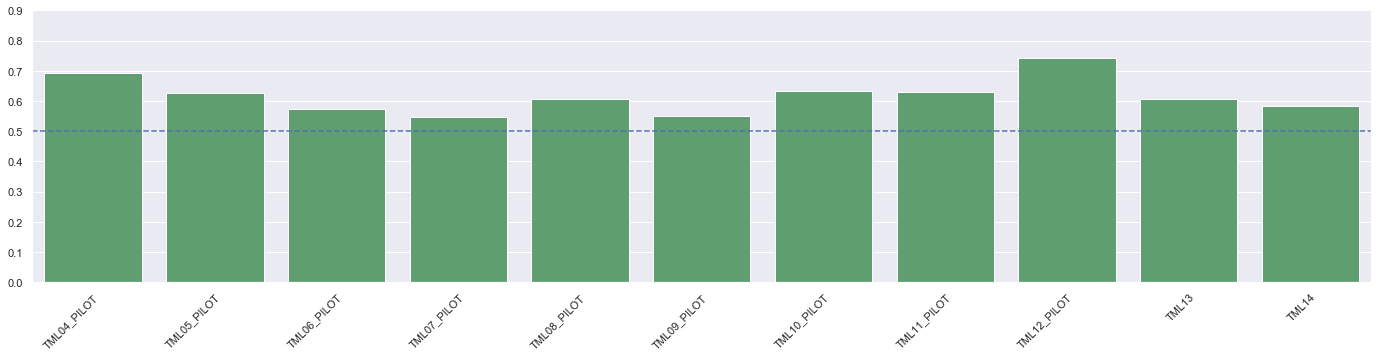

In [71]:
sns.set(rc={'figure.figsize':(24,5)})
ax = sns.barplot(data=df,ci=68,color='g')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.5, ls='--')
ax.set(ylim=(0, 0.9))